In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import zscore
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

**3. How closely does lateness (ADHERENCE) correlate to headway?**

Independent variable belongs on the x-axis and dependent variable belongs on the y-axis.

- Target/ dependent variable (variable you're trying to predict) - headway deviation.
- Predictor/ independent variable (variable you use to make prediction) - adherence. 

Reminder that: 
- ADHERENCE: Difference between actual departure time and scheduled time; negative indicates departure time after scheduled time and positive indicates departure time before scheduled time.
- HDWY_DEV: calculates headway deviation in minutes as the difference between actual and scheduled headway. Negative values indicate a shorter headway than scheduled (i.e. bunching) and positive values indicate a longer headway than scheduled (i.e. gapping). 

In [2]:
headway_data = pd.read_csv("../data/headway_data.csv", delimiter = '\t')
headway_data.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,-0.144444
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,-0.258889


**Correlation Coefficient**

In [3]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(headway_data['ADHERENCE'], headway_data['HDWY_DEV'])

# Print the correlation coefficient
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Pearson Correlation Coefficient: -0.20682243927838445


There seems to be a weak inverse relationship between ADHERENCE (amount of time was early or behind departure schedule) and HDWY_DEV (amount of time you wait at a stop in between buses). The negative means that as one variable increases, the other tends to decrease and vice versa. 

**Scatter Plots** 

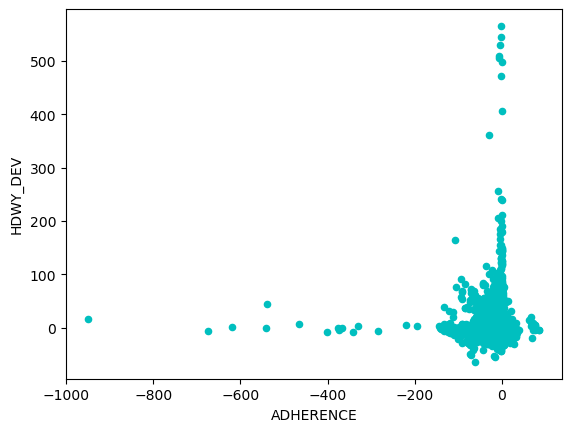

In [4]:
headway_data.plot.scatter(x = 'ADHERENCE', y = 'HDWY_DEV', s = 20, color = 'c'); #cyan

In [5]:
# Filter the DataFrame for positive and neutral adherence values
positive_adherence = headway_data[headway_data['ADHERENCE'] > 1]
neutral_adherence = headway_data[(headway_data['ADHERENCE'] > -1) & (headway_data['ADHERENCE'] < 1)]
negative_adherence = headway_data[headway_data['ADHERENCE'] < -1]

# Calculate statistics for both subsets
positive_stats = positive_adherence['HDWY_DEV'].describe()
neutral_stats = neutral_adherence['HDWY_DEV'].describe()
negative_stats = negative_adherence['HDWY_DEV'].describe()

# Create a DataFrame with the combined statistics
adherence_stats = pd.DataFrame({
    'Adherence Type': ['Positive', 'Neutral', 'Negative'],
    'Count': [positive_stats['count'], neutral_stats['count'], negative_stats['count']],
    'Mean': [positive_stats['mean'], neutral_stats['mean'], negative_stats['mean']],
    'Std': [positive_stats['std'], neutral_stats['std'], negative_stats['std']],
    'Min': [positive_stats['min'], neutral_stats['min'], negative_stats['min']],
    '25%': [positive_stats['25%'], neutral_stats['25%'], negative_stats['25%']],
    '50%': [positive_stats['50%'], neutral_stats['50%'], negative_stats['50%']],
    '75%': [positive_stats['75%'], neutral_stats['75%'], negative_stats['75%']],
    'Max': [positive_stats['max'], neutral_stats['max'], negative_stats['max']]
})

# Display the DataFrame
adherence_stats

,Adherence Type,Count,Mean,Std,Min,25%,50%,75%,Max
0,Positive,8819.0,-3.695143,5.446979,-33.150000,-5.966667,-3.483334,-1.750000,78.050000
1,Neutral,72111.0,-1.677035,5.946462,-32.866667,-3.550000,-1.483334,-0.100000,498.066666
2,Negative,183992.0,1.590440,7.396909,-64.000000,-1.200000,1.166666,3.633333,565.433333


This table shows that: 
- When the bus leaves before the scheduled departure time (positive ADHERENCE), the average time in minutes between the actual and scheduled headway (HDWY_DEV) is about 4 minutes shorter (negative HDWY_DEV). 
- When the bus leaves about on time (neutral adherence), the avg waiting time between buses decreases by about a min and a half (neg HDWY_DEV). 
- When the bus leaves after the scheduled departure time (negative ADHERENCE), the avg waiting time increases to a minute and a half (neutral HDWY_DEV). 

**Linear Regression Model**

lm = smf.ols('target variable ~ predictor variable', data = df).fit()

lm.summary()

In [6]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = headway_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                 1.188e+04
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:20:34   Log-Likelihood:            -8.9492e+05
No. Observations:              265884   AIC:                         1.790e+06
Df Residuals:                  265882   BIC:                         1.790e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2802      0.015    -18.151      0.000      -0.310      -0.250
ADHERENCE     -0.2279      0.002   -109.002      0.000      -0.232      -0.224
==============================================================================
Omnibus:                   525134.358   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       9643452394.096
Skew:                          15.113   Prob(JB):                         0.00
Kurtosis:                     935.498   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.

For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to change by approximately -0.2279 minutes (or about 13.7 seconds) . The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scehduled time), 'HDWY_DEV' is expected to decrease (become more negative).

**Question:** How does adherence at the current stop affects the adherence at the next stop? For a specific trip and day

**Goal:** Use the new data to re-do analysis and to answer the question above. 

In [ ]:
processed_data = pd.read_csv('../data/')